In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
features = ['in_channels', 'out_channels','kernel_size','stride','groups','hw']
raw_data = pd.read_csv('../search_space/regnet_convs_unique.csv')
raw_data_train = raw_data.iloc[:4000, :]
raw_data_test = raw_data.iloc[4000:, :]
raw_data

,in_channels,out_channels,kernel_size,stride,groups,hw
0,1680,1680,3,1,10,7
1,3000,3000,3,2,25,14
2,208,52,1,1,1,14
3,792,792,3,2,11,7
4,448,448,3,2,4,56
...,...,...,...,...,...,...
4818,4,16,1,1,1,112
4819,420,1680,1,1,1,14
4820,2088,2088,3,1,9,14
4821,88,22,1,1,1,28


In [3]:
min_val = raw_data.to_numpy().min(axis=0)
max_val = raw_data.to_numpy().max(axis=0)
for f, a, b in zip(features, min_val, max_val):
    print(f'{f}: {a} - {b}')
scale = max_val - min_val

in_channels: 2 - 3968
out_channels: 2 - 3968
kernel_size: 1 - 3
stride: 1 - 2
groups: 1 - 42
hw: 7 - 112


In [4]:
kernel_size_steps = set(raw_data['kernel_size'])
stride_steps = set(raw_data['stride'])
hw_steps = set(raw_data['hw'])

window = torch.from_numpy(np.ones((1, 1, 3, 3, 3))) * (1 * 1 * 1 / 3 / 3 / 3)
padding = (1, 1, 1)
stride = (1, 1, 1)

def get_distribution(data, kernel_size, stride, hw):
    data_size = len(data)
    freq = 1 / data_size
    data = data[(data['kernel_size'] == kernel_size) & (data['stride'] == stride) & (data['hw'] == hw)]
    data = data[['groups', 'in_channels', 'out_channels']]
    data['in_channels'] = np.ceil(np.log2(data['in_channels'] + 1))
    data['out_channels'] = np.ceil(np.log2(data['out_channels'] + 1))
    data = data.to_numpy().astype(np.int32)
    x = np.zeros((43, 13, 13))
    for row in data:
        x[tuple(row)] += freq
    x = torch.from_numpy(x.reshape([1, 1] + list(x.shape)))
    x = torch.nn.functional.conv3d(x, window, padding=padding, stride=stride)
    x += 1e-10
    return x

def calc_divergence(data1, data2):
    divergence = 0
    for kernel_size in kernel_size_steps:
        for stride in stride_steps:
            for hw in hw_steps:
                p = get_distribution(data1, kernel_size, stride, hw)
                q = get_distribution(data2, kernel_size, stride, hw)
                divergence += torch.sum(p * torch.log(p / q)).item()
    return divergence

def calc_self_divergence(data):
    data1 = data[:len(data) // 2]
    data2 = data[len(data) // 2:]
    return calc_divergence(data1, data2)

In [5]:
kl_labels = [
    calc_self_divergence(raw_data_train),
    calc_self_divergence(raw_data_test),
    calc_divergence(raw_data_train, raw_data_test),
    calc_divergence(raw_data_test, raw_data_train),
]
print(f'KL(x_train, x_train) = {kl_labels[0]}')
print(f'KL(x_test, x_test) = {kl_labels[1]}')
print(f'KL(x_train, x_test) = {kl_labels[2]}')
print(f'KL(x_test, x_train) = {kl_labels[3]}')

KL(x_train, x_train) = 0.2550149858289745
KL(x_test, x_test) = 1.7221191965197644
KL(x_train, x_test) = 0.7004210615064329
KL(x_test, x_train) = 0.1341109569861735


In [6]:
from train_vae import VariationalAutoencoder as VAE

latent_dims = 128
encoder_hidden_dims = 256
decoder_hidden_dims = 256
source_dims = 6
encoder_layers = 5
decoder_layers = 5

def load_vae_model(epoch):
    model0 = VAE(
        latent_dims=latent_dims,
        encoder_hidden_dims=encoder_hidden_dims,
        decoder_hidden_dims=decoder_hidden_dims,
        source_dims=source_dims,
        encoder_layers=encoder_layers,
        decoder_layers=decoder_layers,
    )
    model0.load_state_dict(torch.load(f'./models/ep-{str(epoch).zfill(4)}.model'))
    model0 = model0.cpu()
    model0.eval()
    return model0.decoder


In [7]:
def G(model, z):
    input_z = torch.from_numpy(z).to(torch.float32)
    output_x = model.forward(input_z).detach().numpy()
    output_x[output_x > 1] = 1
    output_x[output_x < 0] = 0
    return output_x * scale + min_val

def R(x):
    return [round(val) for val in x.flatten()]

In [8]:
def generate_data(model, num=2000):
    z = np.random.normal(size=(num, latent_dims))
    x_hat = [R(G(model, row)) for row in z]
    df = pd.DataFrame(data=np.array(x_hat), columns=features)
    return df

In [9]:
def reconstraint_data(x: pd.DataFrame):
    x['kernel_size'] = (np.round((x['kernel_size'] - 1) / 2) * 2 + 1).astype(np.int32)
    x['hw'] = (np.exp2(np.round(np.log2(x['hw'] / 7))) * 7).astype(np.int32)
    x['in_channels'] = (np.round(x['in_channels'] / x['groups']) * x['groups']).astype(np.int32)
    x['out_channels'] = (np.round(x['out_channels'] / x['groups']) * x['groups']).astype(np.int32)
    return x

In [10]:
kl_arr = []
for ep in np.arange(50, 2000, 50):
    model = load_vae_model(ep)
    x_hat = generate_data(model, 2000)
    x_hat = reconstraint_data(x_hat)
    kl_arr.append([
        calc_divergence(raw_data_test, x_hat),
        calc_divergence(x_hat, raw_data_test),
    ])
    print('Epoch', ep)

Epoch 50
Epoch 100
Epoch 150
Epoch 200
Epoch 250
Epoch 300
Epoch 350
Epoch 400
Epoch 450
Epoch 500
Epoch 550
Epoch 600
Epoch 650
Epoch 700
Epoch 750
Epoch 800
Epoch 850
Epoch 900
Epoch 950
Epoch 1000
Epoch 1050
Epoch 1100
Epoch 1150
Epoch 1200
Epoch 1250
Epoch 1300
Epoch 1350
Epoch 1400
Epoch 1450
Epoch 1500
Epoch 1550
Epoch 1600
Epoch 1650
Epoch 1700
Epoch 1750
Epoch 1800
Epoch 1850
Epoch 1900
Epoch 1950


Text(0.5, 0, 'Epochs')

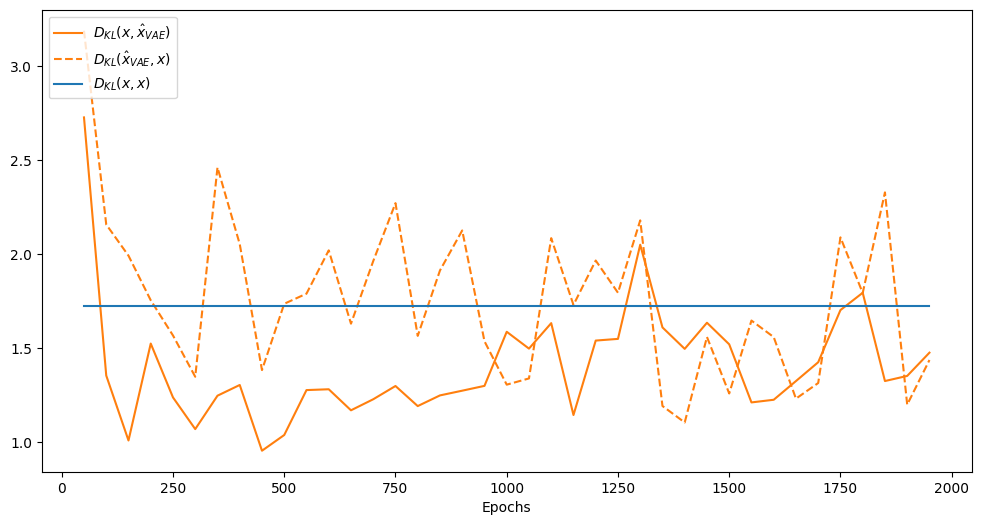

In [11]:
kl_mat = np.array(kl_arr).reshape(-1, 2)
eps = np.arange(50, 2000, 50)

plt.figure(figsize=(12, 6))

ax = plt.subplot(111)
ax.plot(eps, kl_mat[:, 0], color='C1', ls='-', label='$D_{KL}(x, \hat{x}_{VAE})$')
ax.plot(eps, kl_mat[:, 1], color='C1', ls='--', label='$D_{KL}(\hat{x}_{VAE}, x)$')
ax.plot(eps[[0, -1]], [kl_labels[1], kl_labels[1]], color='C0', ls='-', label='$D_{KL}(x, x)$')
ax.legend(loc='upper left')

ax.set_xlabel('Epochs')
# ax.set_ylim([0, 0.5])

In [14]:
np.random.seed(2022)

model = load_vae_model(1900)
x_hat = generate_data(model, 40000)
x_hat = reconstraint_data(x_hat)

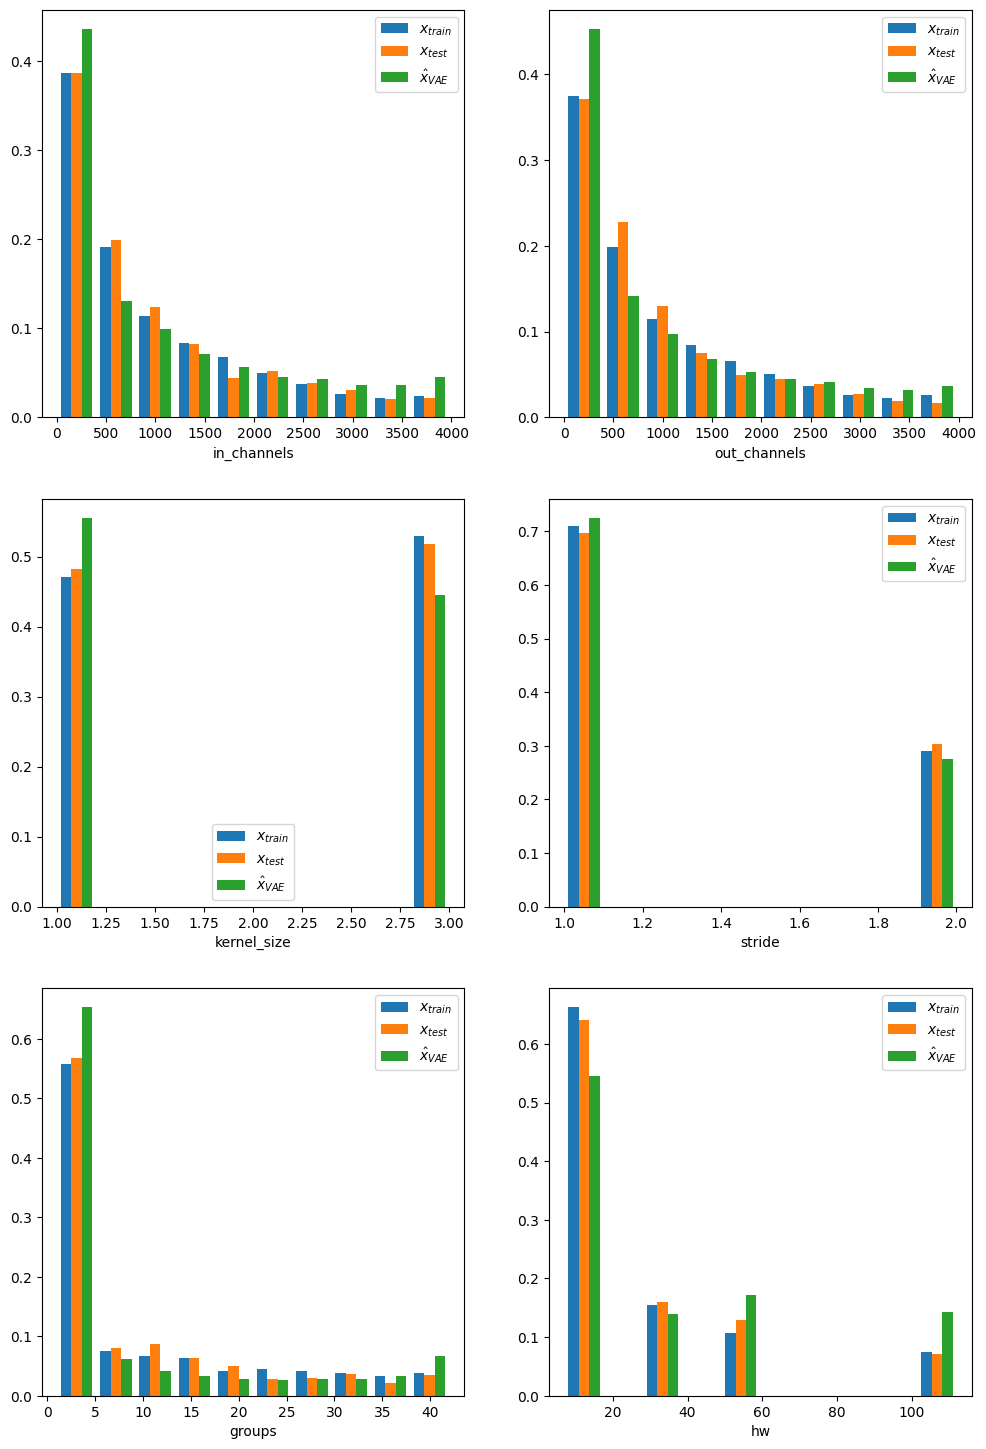

In [15]:
configs = [raw_data_train, raw_data_test, x_hat]
weights = [np.ones((len(x), )) / len(x) for x in configs]
labels = ['$x_{train}$', '$x_{test}$', '$\hat{x}_{VAE}$']

fig = plt.figure(figsize=(12, 18))

for i, feature in enumerate(features):
    ax = plt.subplot(321 + i)
    ax.hist([x[feature] for x in configs], weights=weights, label=labels)
    ax.set_xlabel(feature)
    ax.legend()

In [18]:
with open('../search_space/regnet_convs_expand.csv', 'w') as f:
    f.write(x_hat.to_csv(lineterminator='\n', index=None))

In [19]:
cfg_set = set()
for i, row in x_hat.iterrows():
    cfg_set.add('_'.join([str(s) for s in row[features]]))
len(cfg_set)

34780